# Britain and UK Handbooks as Data

Created in July-September 2020 for the National Library of Scotland's Data Foundry by Lucy Havens, Digital Library Research Intern

### About the *Britain and UK Handbooks* Dataset
The data consists of digitized text from select Britain and UK Handbooks produced between 1954 and 2005.  A central statistics bureau (the Central Statistical Office until 1 April 1966, when it merged with the Office of Population Censuses and Surveys and became the Office for National Statistics) produced the Handbooks each year to communicate information about the UK that would impress international diplomats.  The Handbooks provide a factual skeleton of the UK, focusing on reporting quantitative information and a civil service perspective.

* Data format: digitized text
* Data creation process: Optical Character Recognition (OCR)
* Data source: https://data.nls.uk/digitised-collections/britain-uk-handbooks/

***
### Table of Contents
0. [Preparation](#0.-Preparation)
1. [Data Cleaning and Standardisation](#1.-Data-Cleaning-and-Standardisation)
2. [Summary Statistics](#2.-Summary-Statistics)
3. [Exploratory Analysis](#3.-Exploratory-Analysis)
***

### 0. Preparation
Import libraries to use for cleaning, summarizing and exploring the data:

In [2]:
# To prevent SSL certificate failure
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Libraries for data loading
import pandas as pd
import numpy as np
import string
import re

# Libraries for visualization
import altair as alt
import matplotlib.pyplot as plt

# Libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags
from nltk.draw.dispersion import dispersion_plot as displt

[nltk_data] Downloading package punkt to /Users/lucy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/lucy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/lucy/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package tagsets to /Users/lucy/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


The nls-text-handbooks folder (downloadable as *Just the text* data from the website at the top of this notebook) contains TXT files of digitised text, with numerical names, as well as a CSV inventory file and a TXT ReadMe file.  Load only the TXT files of digitised text and **tokenise** the text (which splits a string into separate words, numbers, and punctuation):

In [3]:
corpus_folder = 'data/nls-text-handbooks/'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*', encoding='latin1')
corpus_tokens = wordlists.words()
print(corpus_tokens[:10])

['BRITAIN', '1979', '3W', '+', 'L', 'Capita', '!', 'Edinburgh', 'Population', '5']


It's hard to get a sense of how accurately the text has been digitized from this list of 10 tokens, so let's look at one of these words in context.  To see phrases in which "Edinburgh" is used, we can use the concordance() method:

In [4]:
t = Text(corpus_tokens)
t.concordance('Edinburgh', lines=20)

Displaying 20 of 2579 matches:
BRITAIN 1979 3W + L Capita ! Edinburgh Population 5 , 196 / GOO ENGLAND A
ondon WC1V 6HB 13a Castle Street , Edinburgh EH2 3AR 41 The Hayes , Cardiff CF1
ield Liverpool Manchester Bradford Edinburgh Bristol Belfast Coventry Cardiff s
Counsellors of State ( the Duke of Edinburgh , the four adult persons next in s
ments , accompanied by the Duke of Edinburgh , and undertakes lengthy tours in 
y government bookshops in London , Edinburgh , Cardiff , Belfast , Manchester ,
five Scottish departments based in Edinburgh and known as the Scottish Office .
 is centred in the Crown Office in Edinburgh . The Parliamentary Draftsmen for 
. The main seat of the court is in Edinburgh where all appeals are heard . All 
 The Court of Session sits only in Edinburgh , and has jurisdiction to deal wit
ersities are : Aberdeen , Dundee , Edinburgh , Glasgow , Heriot - Watt ( Edinbu
nburgh , Glasgow , Heriot - Watt ( Edinburgh ), St . Andrews , Stirling , and S
. Andrews , Gla

I'm guessing `bife` should be `Fife` as it's closely followed by `Dundee`, but overall not so bad!

We can also load individual files from the nls-text-handbooks folder:

In [5]:
file = open('data/nls-text-handbooks/205336772.txt', 'r')
sample_text = file.read()
sample_tokens = word_tokenize(sample_text)
print(sample_tokens[:10])

['GH', '.', 'fl-', '[', 'IASG0', '>', 'J^RSEI', 'nice', ']', 'ROME']


However, in this Notebook, we're interested in the entire dataset, so we'll use all its files.  Let's find out just how many files, and just how much text, we're working with.

#### 0.1 Dataset Size

In [6]:
def corpusStatistics(plaintext_corpus_read_lists):
    total_chars = 0
    total_tokens = 0
    total_sents = 0
    total_files = 0
    for fileid in plaintext_corpus_read_lists.fileids():
        total_chars += len(plaintext_corpus_read_lists.raw(fileid))
        total_tokens += len(plaintext_corpus_read_lists.words(fileid))
        total_sents += len(plaintext_corpus_read_lists.sents(fileid))
        total_files += 1
    print("Total...")
    print("  Characters in Handbooks Data:", total_chars)
    print("  Tokens in Handbooks Data:", total_tokens)
    print("  Sentences in Handbooks Data:", total_sents)
    print("  Files in Handbooks Data:", total_files)

corpusStatistics(wordlists)

Total...
  Characters in Handbooks Data: 90573254
  Tokens in Handbooks Data: 16606800
  Sentences in Handbooks Data: 584618
  Files in Handbooks Data: 50


Note that I've print ``Tokens`` rather than words, though the NLTK method used to count those was ``.words()``.  This is because words in NLTK include punctuation marks and digits, in addition to alphabetic words.

Across the 50 files that make up the Handbooks dataset, there are over 90 million characters (which could be words, numbers, punctuation, abbreviations, etc.), over 16 million words, and nearly 600,000 sentences.  Of course, OCR isn't perfect, so these numbers are estimates, not precise totals.

Variables that store the characters, words, and sentences in our dataset will be useful for future analysis.  Let's create those now:

In [7]:
def getCharsWordsSents(plaintext_corpus_read_lists):
    all_chars = []
    all_words = []
    all_words_lower = []
    all_sents = []
    for fileid in plaintext_corpus_read_lists.fileids():
        
        file_chars = plaintext_corpus_read_lists.raw(fileid)
        all_chars += [str(char).lower() for char in file_chars]
        
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        all_words += [str(word) for word in file_words  if word.isalpha()]
        
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))  #plaintext_corpus_read_lists.sents(fileid)
        all_sents += [str(sent) for sent in file_sents]
        
    return all_chars, all_words, all_words_lower, all_sents
        
handbooks_chars, handbooks_words, handbooks_words_lower, handbooks_sents = getCharsWordsSents(wordlists)

In [8]:
print(handbooks_chars[:10])
print(handbooks_chars[-10:])
print()
print(handbooks_words[:10])
print(handbooks_words[-10:])
print()
print(handbooks_words_lower[:10])
print(handbooks_words_lower[-10:])
print()
sample_sentences = handbooks_sents[:5] + handbooks_sents[-5:]
for s in sample_sentences:
    # remove new lines and tabs at the start and end of sentences
    s = s.strip('\n')
    s = s.strip('\t')
    # remove new lines and tabs in the middle of sentences
    s = s.replace('\n','')
    s = s.replace('\t','')
    print(s)

['b', 'r', 'i', 't', 'a', 'i', 'n', ' ', '1', '9']
['o', 'r', 'e', 's', 'b', 'y', '%', 't', '\r', '\n']

['BRITAIN', 'L', 'Capita', 'Edinburgh', 'Population', 'GOO', 'ENGLAND', 'Area', 'km', 'miles']
['AIRWAYS', 'ADEN', 'ALWAYS', 'BAHAMAS', 'AIRWAYS', 'ASSOCIATES', 'August', 'r', 'MORESBY', 'T']

['britain', 'l', 'capita', 'edinburgh', 'population', 'goo', 'england', 'area', 'km', 'miles']
['airways', 'aden', 'always', 'bahamas', 'airways', 'associates', 'august', 'r', 'moresby', 't']

Capita! 1979
Capita!q.miles.kmGOO
^xt:. i - <1.. i 'i&rr
u.
(between pp 390 and 391).t structure390);olomgssalaries
LABI!BOâr
CHICAGO!EAIATED BY BRITISH OVERSEAS AIRWAYS-BRITISH EUROPEAN AIRWA YS-TRANS-CANADA AIR LINES â¢ Q ANT AS EMPIRE AIRWAYS
GIBRALTAR!
GRAND CAYMAN.
MORESBY%TN A1RWA VS â¢ TASMAN EMPIRE AIRWA YS- BRITISH WEST INDIAN AIRWAYS-ADEN ALWAYS BAHAMAS AIRWAYS'* ASSOCIATES


`bife` isn't the only word the OCR incorrectly digitised.  To get a sense of how much of the digitised text we can perform meaningful analysis on, let's figure out how many of NLTK's "words" are actually recognisable English words.  We'll use [WordNet](https://wordnet.princeton.edu/),* a database of English words, to evaluate which of NLTK's "words" are not valid English words.  Section 1. Data Cleaning and Standardisation walks through how to estimate the amount digitisation mistakes.
***
  **Princeton University "About WordNet." WordNet. Princeton University. 2010.*

#### 0.2 Identifying Subsets of the Data
Before we move onto cleaning and standardisation, we'll create a lists and dictionary that will help us easily access subsets of the Handbooks data.  First need to load the inventory (CSV file) that lists which file name corresponds with which text in the Handbooks dataset.  When you open the inventory in Microsoft Excel or a text editor, you can see that there are no column names.  The Python library [Pandas](https://pandas.pydata.org/docs/), which reads CSV files, calls these column names the ``header``.  When we use Pandas to read the inventory, we'll create our own header by specifying that the CSV file as ``None`` and providing a list of column ``names``.

When Pandas (abbreviated ``pd`` when we loaded libraries in the first cell of this notebook) reads a CSV file, it creates a table called a **DataFrame** from that data.  Let's see what the Handbooks inventory DataFrame looks like:

In [9]:
df = pd.read_csv('data/nls-text-handbooks/handbooks-inventory.csv', header=None, names=['fileid', 'title'])
df.head()  # df.head() returns the first 5 rows of a table, df.tail() returns the last 5 rows of the table, and df returns the entire table

,fileid,title
0,189742208.txt,Britain: An official handbook - 1979 - GII.11
1,189742209.txt,Britain: An official handbook - 1980 - GII.11
2,189742210.txt,Britain: An official handbook - 1981 - GII.11
3,189742211.txt,Britain: An official handbook - 1982 - GII.11
4,189742212.txt,Britain: An official handbook - 1983 - GII.11


It looks like the titles of the handbooks in this collection changes over time!  The returned DataFrame (the inventory table) isn't showing the entire titles, so let's increase the maximum width of the columns:

In [10]:
pd.set_option('display.max_colwidth', 150)
df.tail()

,fileid,title
45,204486117.txt,Britain: The official yearbook of the United Kingdom - 2001 - GII.11
46,204882221.txt,UK: The official yearbook of the United Kingdom of Great Britain and Northern Ireland - 2002 - GII.11 SER
47,204882222.txt,UK: The official yearbook of the United Kingdom of Great Britain and Northern Ireland - 2003 - GII.11 SER
48,204882223.txt,UK: The official yearbook of the United Kingdom of Great Britain and Northern Ireland - 2005 - GII.11 SER
49,205336772.txt,Britain: An official handbook - 1955 - GII.11


Perfect!  Now we can see the full titles for each Handbook file.  It looks like they're not in chronological order, so let's sort the DataFrame by `title`:

In [11]:
df = df.sort_values(by=['title'])
# df

<div class="alert alert-block alert-info">
<b>Try It!</b> Uncomment the last line of code in the cell above by removing the `#` before `df` to see the sorted DataFrame.  Are the titles ordered chronologically?
</div>

With a DataFrame, we can access individual cells, for example: 

In [12]:
# To view the first (index = 0) row's fileid and title:
print(df.iloc[0][0], df.iloc[0][1])
# To view a title value given a fileid value:
print(df[df.fileid == '204882223.txt']['title'].values[0])
# To view a fileid value given a title value
print(df.loc[df['title'] == 'Britain: An official handbook - 1955 - GII.11'].values[0][0])

204486084.txt Britain: An official handbook - 1954 - GII.11
UK: The official yearbook of the United Kingdom of Great Britain and Northern Ireland - 2005 - GII.11 SER
205336772.txt


Now we can create a two dictionaries of fileids and their associated journal titles, so we can easily identify which wordlists correspond with which text in the Handbooks dataset (you can uncomment any lines of code by removing the `#` to see what they print):

In [13]:
# 1. Obtain a list of all file IDs
fileids = list(df["fileid"])
# print("Sample file IDs from list of file IDs:\n", fileids[-5:])
# print()

# 2. Obtain a list of all titles
titles = list(df["title"])
# print("Sample titles from list of titles:\n", titles[-5:])
# print()

# 3. Create a dictionary where the keys are file IDs and the values are titles
inventory = dict(zip(fileids, titles))
# print(inventory)
# print()

# 4. Pick a file ID by its index number...
i = 10
a_file_id = fileids[i]
# ... and get the title corresponding with the file ID in the inventory dictionary
print("The title for the file ID at index " + str(i) + ":\n", inventory[a_file_id])

The title for the file ID at index 10:
 Britain: An official handbook - 1965 - GII.11


Python's Natural Language Toolkit (NLTK) library, which we use for text analysis later on, stores the lists of tokens (``worldists`` in the `corpus_tokens` variable we created) by the file IDs, so it's useful to be able to match the file IDs with their handbook text! 

*However*, the previous `corpus_tokens` is based on the unsorted collection of `wordlists` for the Handbooks dataset.  Let's fix that:

In [14]:
def getSortedWordsSents(plaintext_corpus_read_lists):
    all_words = []
    all_words_lower = []
    all_sents = []
    
    # Iterate through the list of SORTED fileids so that 
    # the words and sentences are tokenized in chronological order
    for fileid in fileids:
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        all_words += [str(word) for word in file_words  if word.isalpha()]
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))  
        all_sents += [str(sent) for sent in file_sents]
        
    return all_words, all_words_lower, all_sents
        
handbooks_words, handbooks_words_lower, handbooks_sents = getSortedWordsSents(wordlists)

Now, using the tokens in `handbooks_words`, `handbooks_words_lower`, and `handbooks_sents`, we can analyse changes in the Handbooks dataset over time!

### 1. Data Cleaning and Standardisation

There are several ways to standardise, or "normalise," text, with each way providing suitable text for different types of analysis.  For example, to study the vocabulary of a text-based dataset, it's useful to remove punctuation and digits, lowercase the remaining alphabetic words, and then reduce those words to their root form (with stemming or lemmatisation - more on this later).  Alternatively, to identify people and places using named entity recognition, it's important to keep capitalisation in words and keep words in the context of their sentences.

#### 1.1 Tokenisation
In section **0. Preparation**, we tokenised the Handbooks dataset when we created the ``corpus_tokens`` list.  ``corpus_tokens`` contains a list of all words, numbers, and punctuation that appear in the Handbooks dataset separated into individual items and organised in the order they appear in the LEDS text files.  In addition to tokenising words, NLTK also provides methods to tokenise sentences.  This is how we counted the number of sentences in section **0.1 Dataset Size**.

Tokenized words are helpful when analysing the vocabulary of text. Tokenised sentences are helpful when analysing linguistic patterns of a text.  Let's create lists of tokens as *strings* (String is Python's data format for text) from the LEDS dataset:

**Step 1:** First, let's create a list of strings from the words NLTK has identified for us:

In [15]:
str_tokens = [str(word) for word in handbooks_words]
assert(type(str_tokens[0]) == str)  # quick test to make sure the output is as expected
print(str_tokens[0:10])

['m', 'Gti', 'i', 'BRITAIN', 'An', 'Official', 'Handbook', 'BRITAIN', 'An', 'Official']


There are digits and punctuation that won't be recognized as words in WordNet but still provide valuable text data for studying the Handbooks.  For example, in the output above, it looks as though the OCR processed the word `Capital` as `Capita!`, which NLTK has split into two.  Furthermore, the word '1979' is a date that puts the text in context, which would enable one to order information in the text by date.

**Step 2:** To get an estimate of how accurately OCR digitized the Handbooks, though, we'll use words in the sense that they are recognizable words in the English language.  Let's write a regular expression that can tell us whether a string is a word or abbreviation:

In [16]:
isWord = re.compile('[a-zA-z.]+')  # include single letters and abbreviations

# ----------- TESTING REGEX -----------
# print(isWord.match("bife").group())
# print(isWord.match("U.S.A.").group())
# print(isWord.match("W").group())
# print(isWord.match("1979") == None)

**Step 3:** Lastly, let's use that regular expression to write a function to distinguish words recognizable English words from unrecognizable strings:

In [17]:
def removeNonEnglishWords(list_of_strings):
    english_only = []
    nonenglish = []
    for s in list_of_strings:
        test = isWord.match(s)            # fails if has characters other than letters or a period
        if (test != None):
            passed = test.group()   # get the matching string
            if wordnet.synsets(passed):  # see if WordNet recognizes the matching string
                english_only.append(passed)
            else:
                nonenglish.append(passed)
        else:
            nonenglish.append(passed)
    return english_only, nonenglish
                
recognised, unrecognised = removeNonEnglishWords(str_tokens)

In [18]:
print("Total alphabetic words recognised in WordNet:", len(recognised))
print("Total alphabetic words NOT reccognised in WordNet:", len(unrecognised))
print("Percentage of alphabetic words that are unrecognised in WordNet:", (len(unrecognised)/len(recognised))*100, "%")

Total alphabetic words recognised in WordNet: 9652429
Total alphabetic words NOT reccognised in WordNet: 3422753
Percentage of alphabetic words that are unrecognised in WordNet: 35.460017369721136 %


Note that these totals and percentage should be used as rough estimates, not precise calculations.  WordNet may not recognise some British English terms since it was developed at Princeton, an American university.  There are other data sources that provide lists of valid words to which you could compare words from the Handbooks dataset.  Using a combination of several sources of valid English words could provide more accurate estimates.

Different types of analysis require different subsets of data, so let's create some now.  To begin, we'll create lists of the handbooks tokens where all words are lowercased:

In [19]:
# Lowercase text
lower_str_tokens = [t.lower() for t in str_tokens]
lower_recognised = [word.lower() for word in recognised]
lower_unrecognised = [word.lower() for word in unrecognised]    

Next we'll create a list of the lowercase tokens that excludes stop words, such as `as`, `a`, and `the`:

In [20]:
# Exclude stop words (i.e. the, a, is) - note that the input text must be lowercased!
eng_stopwords = set(stopwords.words('english'))
no_stopwords = [t for t in lower_str_tokens if not t in eng_stopwords]
assert(len(no_stopwords) < len(str_tokens))

#### 1.2 Stemming
In addition to tokenisation, **stemming** is a method of standardising, or "normalising," text.  Stemming reduces words to their root form by removing suffixes.  For example, the word "troubling" has a stem of "troubl."  NLTK has two types of stemmers that use different algorithms to determine what the root of a word is.  

The stemming algorithms can take several minutes to run, so two are provided below with one commented out (the lines begin with ``#``) so it won't run.  If you'd like to see how the stemming algorithms differ, uncomment the lines by highlighting them and pressing ``cmd`` + ``/``.

First, though, let's see what stems of Handbooks data look like with the Porter Stemmer:

In [21]:
# Stem the text (reduce words to their root, whether or not the root is a word itself
porter = nltk.PorterStemmer()
porter_stemmed = [porter.stem(t) for t in lower_str_tokens if t.isalpha()]  # only include alphabetic tokens
print(porter_stemmed[500:600])

['be', 'place', 'on', 'gener', 'sale', 'and', 'it', 'wa', 'final', 'decid', 'to', 'do', 'thi', 'after', 'a', 'recommend', 'by', 'the', 'inter', 'department', 'committe', 'on', 'social', 'and', 'econom', 'research', 'the', 'handbook', 'contain', 'factual', 'and', 'statist', 'inform', 'compil', 'from', 'authorit', 'and', 'offici', 'sourc', 'about', 'the', 'unit', 'kingdom', 'it', 'peopl', 'and', 'it', 'institut', 'it', 'doe', 'not', 'claim', 'to', 'be', 'comprehens', 'it', 'princip', 'purpos', 'is', 'to', 'provid', 'basic', 'data', 'on', 'the', 'main', 'aspect', 'of', 'nation', 'administr', 'and', 'nation', 'economi', 'and', 'to', 'give', 'an', 'account', 'of', 'the', 'part', 'play', 'by', 'the', 'govern', 'in', 'the', 'life', 'of', 'the', 'commun', 'in', 'consid', 'it', 'content', 'reader', 'in', 'the', 'unit', 'kingdom']


In [ ]:
# lancaster = nltk.LancasterStemmer()
# lancaster_stemmed = [lancaster.stem(t) for t in lower_str_tokens if t.isalpha()] # only include alphabetic tokens
# print(lancaster_stemmed[500:600])

<div class="alert alert-block alert-info">
<b>Try It!</b> Uncomment the lines of code in the cell above by removing the `#` before each line to see how a different stemming algorithm works: the Lancaster Stemmer.  What differences do you notice in the sample of stems that are returned?
</div>

Another approach to reducing words to their root is to **lemmatise** tokens.  NLTK's WordNet Lemmatizer reduces a token to its root *only* if the reduction of the token results in a word that's recognized as an English word in WordNet.  Here's what that looks like:

In [22]:
# Lemmatize the text (reduce words to their root ONLY if the root is considered a word in WordNet)
wnl = nltk.WordNetLemmatizer()
lemmatised = [wnl.lemmatize(t) for t in lower_str_tokens if t.isalpha()]  # only include alphabetic tokens
print(lemmatised[500:600])

['be', 'placed', 'on', 'general', 'sale', 'and', 'it', 'wa', 'finally', 'decided', 'to', 'do', 'this', 'after', 'a', 'recommendation', 'by', 'the', 'inter', 'departmental', 'committee', 'on', 'social', 'and', 'economic', 'research', 'the', 'handbook', 'contains', 'factual', 'and', 'statistical', 'information', 'compiled', 'from', 'authoritative', 'and', 'official', 'source', 'about', 'the', 'united', 'kingdom', 'it', 'people', 'and', 'it', 'institution', 'it', 'doe', 'not', 'claim', 'to', 'be', 'comprehensive', 'it', 'principal', 'purpose', 'is', 'to', 'provide', 'basic', 'data', 'on', 'the', 'main', 'aspect', 'of', 'national', 'administration', 'and', 'national', 'economy', 'and', 'to', 'give', 'an', 'account', 'of', 'the', 'part', 'played', 'by', 'the', 'government', 'in', 'the', 'life', 'of', 'the', 'community', 'in', 'considering', 'it', 'content', 'reader', 'in', 'the', 'united', 'kingdom']


To study the linguistic style of text, analysing the **parts of speech** and their patterns in sentences can be useful.  NLTK has a method for tagging tokens with a part of speech in a sentence.  Let's do that too:

In [23]:
# Tag parts of speech in sentences
sentences = wordlists.sents()  # sentences = [nltk.word_tokenize(sent) for sent in sentences]
pos_tagged = [nltk.pos_tag(sent) for sent in sentences]
print(pos_tagged[:1])
# less likely to have as many descriptive words as novel, more factual

[[('BRITAIN', 'NNP'), ('1979', 'CD'), ('3W', 'CD'), ('+', 'NN'), ('L', 'NNP'), ('Capita', 'NNP'), ('!', '.')]]


NLTK uses abbreviations to identify parts of speech, such as:
* `NN` = singular noun, `NNS` = plural noun, `NNP` = singular proper noun, `NNPS` = plural proper noun
* `IN` = preposition
* `TO` = preposition or infinitive marker
* `DT` = determiner
* `CC` = coordinating conjunction
* `JJ` = adjective
* `VB` = verb
* `RB` = adverb

More abbreviations are explained [here](https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/) or can be queried with `nltk.help.upenn_tagset('TAG')`

### 2. Summary Statistics

#### 2.1 Frequencies and Sizes

Now that we've created some different cuts of the Handbooks dataset, let's start investigating the frequency of terms as they appear across the dataset.  One way to do so is with a **frequency distribution**, which is a line chart that shows how many times a token appears in the dataset.

Let's plot the frequency distribution using tokens that were recognised by WordNet as English words, excluding the same stop words, digits, and punctuation as above:

In [24]:
rec_min_two_letters = [t for t in lower_recognised if len(t) > 2]
to_exclude = set(stopwords.words('english') + list(string.punctuation) + list(string.digits) + ['also', 'per', '000', 'one', 'many', 'may', 'two', 'see'])
filtered_rec_tokens = [t for t in rec_min_two_letters if not t in to_exclude]
fdist_ft_rec = FreqDist(filtered_rec_tokens)
fdist_ft_rec.N()  # count the total tokens after filtering

7219577

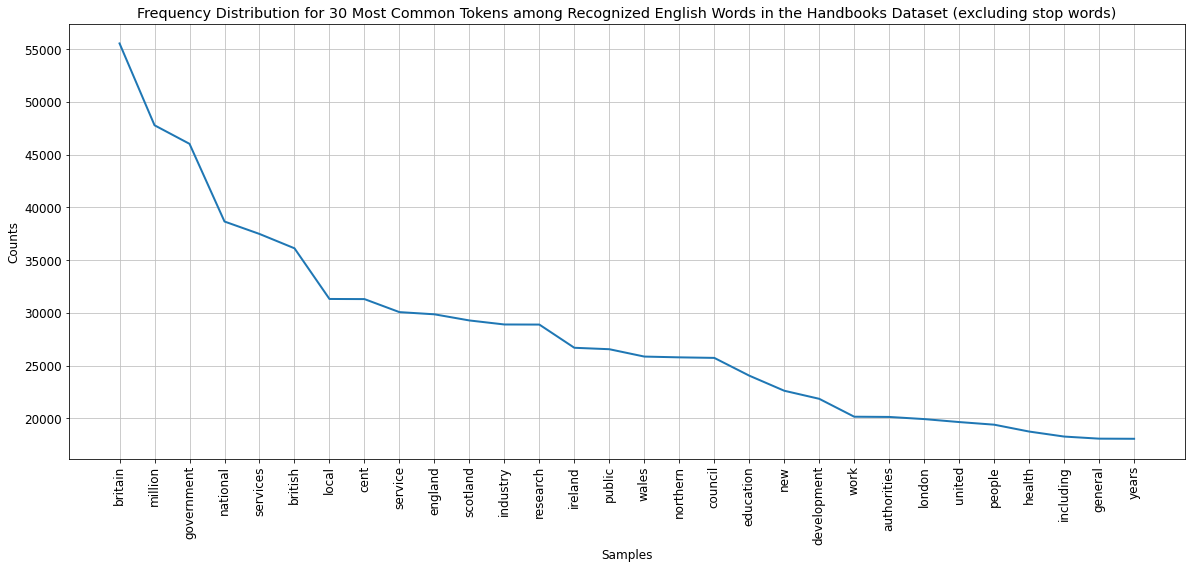

In [25]:
plt.figure(figsize = (20, 8))
plt.rc('font', size=12)

number_of_tokens = 30 # Try increasing or decreasing this number to view more or fewer tokens in the visualization
fdist_ft_rec.plot(number_of_tokens, title='Frequency Distribution for ' + str(number_of_tokens) + ' Most Common Tokens among Recognized English Words in the Handbooks Dataset (excluding stop words)')

We can create a data visualisation that illustrates when specific words are used within the Handbooks dataset.  This is called a **Lexical Dispersion Plot**.  We'll pick some place names (the list of `targets`) to see when they appear:

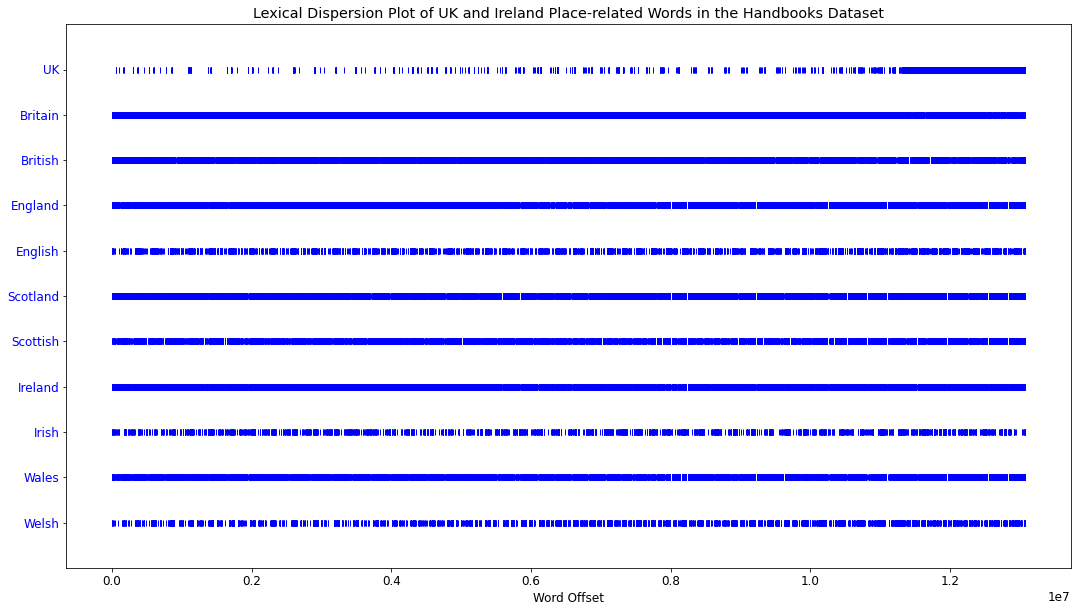

In [26]:
corpus_text = Text(handbooks_words)
targets = ['UK', 'Britain', 'British', 'England', 'English', 'Scotland', 'Scottish', 'Ireland', 'Irish', 'Wales', 'Welsh']
plt.figure(figsize=(18,10))
plt.rc('font', size=12)
displt(corpus_text, targets, ignore_case=True, title='Lexical Dispersion Plot of UK and Ireland Place-related Words in the Handbooks Dataset')

# industries (some disappear over time), closure of mines in 80s, sports (football, what others?)
# topic remains each year - consistency is part of value, amount of detail is what varies - could pick out where differences occur by comparing sections of text over years? pages devoted to particular topic

Since we sorted the Handbooks tokens by date, the lexical dispersion plot is showing changes in the use of our list of target words (tokens) over time, with the earliest publications to the left and the most recent publications to the right!  We can see that the word `UK` is used with increasing frequency over time.  We can also see that `English`, `Welsh`, and `Irish` occur less than `British` and `Scottish`.

<div class='alert alert-block alert-info'>
    <b>Try It!</b> Instead of tokens, visualise the frequency distribution of lemmas or stems, and pick your own list of targets!
</div>

#### 2.2 Uniqueness and Variety

Another way to summarise the Handbooks dataset is to look at the uniqueness and variety of word usage.  We can obtain the **vocabulary** of the text by creating a set of unique tokens that occur in the dataset, as well as creating a set of unique *lemmatised* tokens that occur in the dataset.

In [27]:
# Remove duplicate tokens from the text (obtain the vocabulary of the text)
t_vocab = set(str_tokens)
t_vocab_lower = set(lower_str_tokens)
lemma_vocab = set(lemmatised)
print("Unique tokens:", len(t_vocab))
print("Unique lowercase tokens:", len(t_vocab_lower))
print("Unique lemmatised (lowercase) tokens:", len(lemma_vocab))
print()
rec_vocab = set(recognised)
rec_vocab_lower = set(lower_recognised)
unrec_vocab = set(unrecognised)
unrec_vocab_lower = set(lower_unrecognised)
print("Unique recognised words:", len(rec_vocab))
print("Unique recognised lowercase words:", len(rec_vocab_lower))
print("Unique unrecognised words:", len(unrec_vocab))
print("Unique unrecognised lowercase words:", len(unrec_vocab_lower))

Unique tokens: 72489
Unique lowercase tokens: 57422
Unique lemmatised (lowercase) tokens: 52713

Unique recognised words: 36742
Unique recognised lowercase words: 25590
Unique unrecognised words: 33606
Unique unrecognised lowercase words: 30240


The vocabulary of the entire Handbooks dataset contains 70,922 unique words, 36,780 of which are recognised English words in WordNet. The lemmatised vocabulary of the dataset contains 66,172 words.

In [28]:
print(list(lemma_vocab)[:100])

['wholesalmg', 'parâ', 'jody', 'ptr', 'reciprocally', 'penal', 'hall', 'html', 'penitentiary', 'dowdâ', 'aexcluding', 'registerâ', 'sheriffdâ', 'hampering', 'correspondence', 'ebfencesearepbeing', 'torridon', 'nua', 'unionst', 'void', 'competitor', 'anglesey', 'pres', 'madley', 'skye', 'aax', 'originâ', 'disappeared', 'victory', 'customerâ', 'sleeping', 'swn', 'sustenance', 'cfm', 'ccta', 'pollutantsâ', 'aldermaston', 'accrued', 'maladministâ', 'stationeiy', 'qatar', 'agâ', 'dj', 'brewing', 'harmonisation', 'thereto', 'reaped', 'scaffolding', 'expe', 'fallâ', 'latvia', 'conscious', 'moval', 'peoplesâ', 'porterw', 'eside', 'oct', 'martinstown', 'crimea', 'trackâ', 'twelve', 'ringway', 'recognizably', 'spoil', 'instrumenâ', 'selected', 'cher', 'nazionali', 'ity', 'tendering', 'americanâ', 'pational', 'internally', 'julius', 'successâ', 'polaris', 'lanark', 'limehouse', 'trevelyan', 'pontypool', 'worse', 'iiq', 'drivenâ', 'tjgl', 'powerger', 'generator', 'iddermir', 'unemploy', 'info', 'b

Since the Handbooks dataset contains multiple publications (one file per year of publication), we could try picking a subset of publications, or even a single publication, and then compare the vocabulary across different publications.  What patterns would you expect to see?

### 3. Exploratory Analysis

Let's group the Handbooks TXT files into 10-year periods so that we investigate patterns in the Handbooks text over time, comparing one decade to the next.

**Step 1:** We'll extract the date from each title of the Handbooks dataset using [Regular Expressions](https://www.w3schools.com/python/python_regex.asp), which enable us to specify patterns to look for that may be a combination of letters, digits, punctuation, or white space:

In [31]:
# We can use the 'titles' list we created in 'Section 0. Preparation'
dates = []
for title in titles:
    # Write a Regular Expression to extract the date from the title
    # (I find it helpful to text out Regular Expressions with Pythex: https://pythex.org/)
    # and turn the date into an Integer, so we can analyse it like a number
    yr = int((re.search('\d{4}', title))[0])
    dates += [yr]
print(dates)

[1954, 1955, 1956, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2005]


**Step 2:** Now we'll associate the extracted years with their titles and fileids, adding them to the DataFrame in a column named `year`:

In [34]:
df['year'] = dates
df.head()

,fileid,title,year
12,204486084.txt,Britain: An official handbook - 1954 - GII.11,1954
49,205336772.txt,Britain: An official handbook - 1955 - GII.11,1955
13,204486085.txt,Britain: An official handbook - 1956 - GII.11,1956
14,204486086.txt,Britain: An official handbook - 1958 - GII.11,1958
15,204486087.txt,Britain: An official handbook - 1959 - GII.11,1959


**Step 3:** We'll group the fileids in the Handbooks dataset by decade:

In [44]:
# INPUT: a list of years, and a dictionary with those years (in Integer
#        format) as keys and a list of ids (in String format) as values
# OUTPUT: a dictionary with a key for every tenth year, beginning with the
#         first year in the list, and values that are lists of ids associated
#         with the 10-year period
def groupByDecade(yrs, yrs_to_ids):
    y = yrs[0]
    last = yrs[-1] + 10
    file_groups = {}
    while y <= last:
        decade_list = []
        for yr,fileid in yrs_to_ids.items():
            if yr <= (y + 9):
                decade_list += [fileid]
        file_groups[y] = decade_list
        y += 10
    return file_groups

# Make a dictionary with years as keys and fileids as values
list_of_years = list(df['year'])
year_to_fileid = dict(zip(yrs, fileids))

# Run the function to get a list of fileids by each 10-year period in the Handbooks, starting with the first year a Handbook was published
file_groups = groupByDecade(list_of_years, year_to_fileid)

# Uncomment the code lines below to see the files in each 10-year group
# (you can quickly comment/uncomment multiple code lines by highlighting them
# and pressing, for PCs, 'ctrl' + '/' or, for Macs, 'cmd' + '/')

# for key,value in file_groups.items():
#     print(key)
#     print(value)
#     print()

**Step 4:** Lastly, we'll word-tokenize and sentence-tokenize the groups of files, so that we can analyze the Handbooks' evolution over 10-year periods:

In [53]:
# INPUT: a wordlist (from the PlaintextCorpusReader - see section 0. Preparation) and
#        a year and a list of fileids associated with that year
# OUTPUT: a list of word tokens and and a list of sentence tokens for fileids from
#         with the inputted year through the next 9 years (totalling a 10-year period)
def getTokens(plaintext_corpus_read_lists, group_year, year_files):
    all_words = []
    all_words_lower = []
    all_sents = []
    for fileid in year_files:
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        all_words += [str(word) for word in file_words  if word.isalpha()]
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))  
        all_sents += [str(sent) for sent in file_sents]
        
    return all_words, all_words_lower, all_sents
        
first_words, first_words_lower, first_sentences = getTokens(wordlists, list_of_years[0], file_groups[list_of_years[0]])

In [ ]:
def tokensByDecade(plaintext_corpus_read_lists, list_of_years, file_groups):
    max_i = len(list_of_years)
    i = 0
    decade_words = {}
    decade_words_lower = {}
    decade_sents = {}
    while i < max_i:
        yr = list_of_years[i]
        word_tokens, word_lower_tokens, sent_tokens = getTokens(wordlists, yr, file_groups[yr])
        decade_words[yr] = word_tokens
        decade_words_lower[yr] = word_lower_tokens
        decade_sents[yr] = sent_tokens
    return decade_words, decade_words_lower, decade_sents

decade_words, decade_words_lower, decade_sents = tokensByDecade(wordlists, list_of_years, file_groups)

Great!  Now we can analyse the Handbooks dataset by 10-year periods!

#### 3.1 How are the United Kingdom and Great Britain portrayed?  How does this change over time?

The Handbooks were written for an international audience to impress people with the success and strength of Britain and the UK.  Let's investigate how Britain and the UK are portrayed:

In [ ]:
t = Text(corpus_tokens)
t.concordance('Britain', lines=10)

In [ ]:
fdist = FreqDist(str_tokens)
print("Frequency (percentage) of Britain and the UK in Handbooks dataset:")
print(" - Britain:", (fdist.freq('Britain'))*100, "%")
print(" - GB:", (fdist.freq('GB'))*100, "%")
print(" - UK:", (fdist.freq('UK'))*100, "%")

Let's group the handbooks data into 10-year periods.  We'll use our inventory (the dictionary created in [0.2](#####-0.2-Identifying-Subsets of-the-Data)) to determine the year each handbook was published:

In [ ]:
# economy (monetary terms), how Britain sees itself

In [ ]:
# visualisations go here - frequency of words over time and per volume

<div class='alert alert-box alert-info'>
    <b>Try It!</b> How is Scotland portrayed?  How does the portrayal of Britain and the UK compare or contrast with the portrayal of Scotland?
</div>

In [ ]:
t.concordance('Scotland', lines=10)
# t.concordance('Ireland')  # re.search(.{20}'(?<!Northern )Ireland.{20}')
# t.concordance('Wales')
# t.concordance('England')

In [ ]:
# HINT 1: try using Regular Expressions, like the example below, to search for words related to Scotland and Scottish-ness...

# scot_strings = [s for s in lower_str_tokens if (re.search('scot$', s) or re.search('scot[tcls]+', s))]
# print("Total tokens related to Scotland:", len(scot_strings))

# HINT 2: Sets in Python are similar to Lists except that they can't have repeating items, 
#         so changing a list to a set is a quick way to remove duplicates from a list!
# unique_scot = set(scot_strings)
# print("Unique tokens related to Scotland:", len(unique_scot))
# print(unique_scot)